<a href="https://colab.research.google.com/github/guilhermecchacur/deteccaofraude/blob/main/Estudo_Detec%C3%A7%C3%A3o_de_Fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importando os dados**
Nesse estudo, os dados utilizados serão de uma base fornecida por empresas européias de cartão de crédito, que pode ser encontrado [nesse link](https://www.kaggle.com/mlg-ulb/creditcardfraud).

O dataset contém transações de cartão de crédito registradas em Setembro de 2013, coletadas no período de dois dias. Foram registradas aproximadamente 290.000 transações nesse período, das quais 492 foram fraudulentas.

Todos os registros foram descaracterizados, por questões de privacidade, fazendo com que ficassem todos númericos. Estão representados por colunas anônimas, como: **V1**, **V2**, **V3** e etc.

As variáveis passaram por um processo de Análise de Componentes Principais (Principal Component Analysis - PCA). A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados componentes.




In [ ]:
!pip install pywaffle -q
!pip install scikit-plot -q


     |████████████████████████████████| 565 kB 4.9 MB/s 


In [ ]:

#importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pywaffle import Waffle
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import scikitplot as skplt

In [ ]:
#criando um dataframe 
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

df = pd.read_csv(file_path)


In [ ]:
#criando o dataframe de teste
df_test = df.sample(frac=0.15, random_state=0)

#criando do dataframe de treino
df_train = df.drop(df_test.index)

print(f'Dimensões do DataFrame original: {df.shape}')
print(f'Dimensões do DataFrame teste:\t {df_test.shape}')
print(f'Dimensões do DataFrame treino:\t {df_train.shape}')

Dimensões do DataFrame original: (284807, 31)
Dimensões do DataFrame teste:	 (42721, 31)
Dimensões do DataFrame treino:	 (242086, 31)


#**Análise Exploratória**


Com os 5 primeiros registros, podemos ver os dados trasnformados em descaracterizados e númericos pelo processo de PCA. Somente as variavies **Time** e **Amount** que foram preservadas, sendo:
  * **Time** - variação do tempo, em segundos, entre esse registro e o primeiro registro do dataset.
  * **Amount** - valor da transação.

A variável alvo está na coluna **Class**, que representa se a transação foi fraudulenta ou não. Sendo, **0 - normal** e **1 - fraudulenta**.

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Como pode ser visto no resumo estatístico e nos valores nulos das colunas, o dataset parece estar limpo e sem a necessidade de maiores manipulações.

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df.isnull().sum().max()

0

A quantidade entre transações fraudulentas e normais é muito diferente, como dito anteriormente, somente 492. Com uma visualização gráfica isso se torna mais aparente, como mostrado abaixo. Dessa forma, devemos fazer um balanceamento entre as classes para o modelo se ajustar melhor.
 

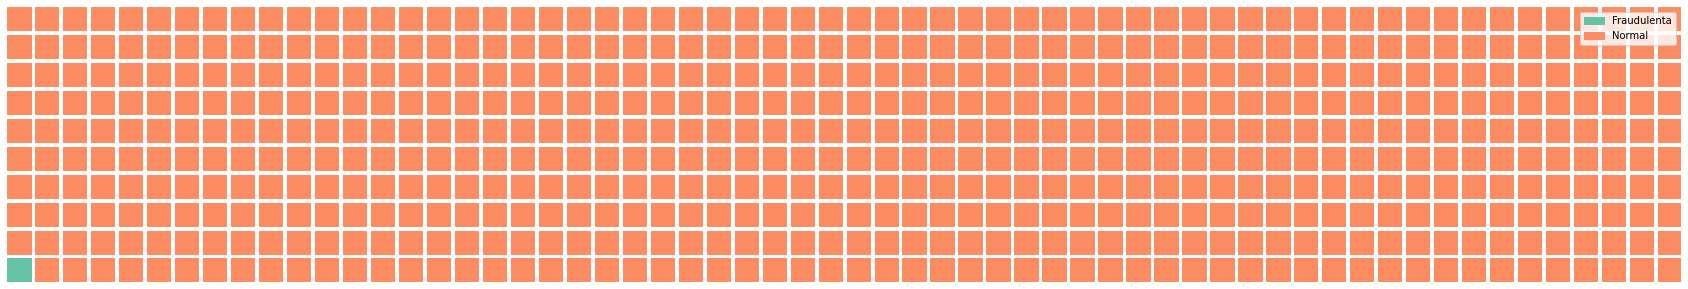

In [ ]:
a = {'Fraudulenta': df.loc[df.Class == 1].Class.count(), 'Normal': df.loc[df.Class == 0].Class.count()}
#fig, ax = plt.subplots()

fig = plt.figure(
                FigureClass=Waffle,
                rows=10,
                columns=60,
                values = a,
                 figsize = [30,30])

fig.set_tight_layout(False)
plt.show()

Podemos tentar tirar alguma informação das variáveis Time e Amount, em relação ao tipo de transação. Usando um histograma para cada uma delas, podemos ver como se comportam.


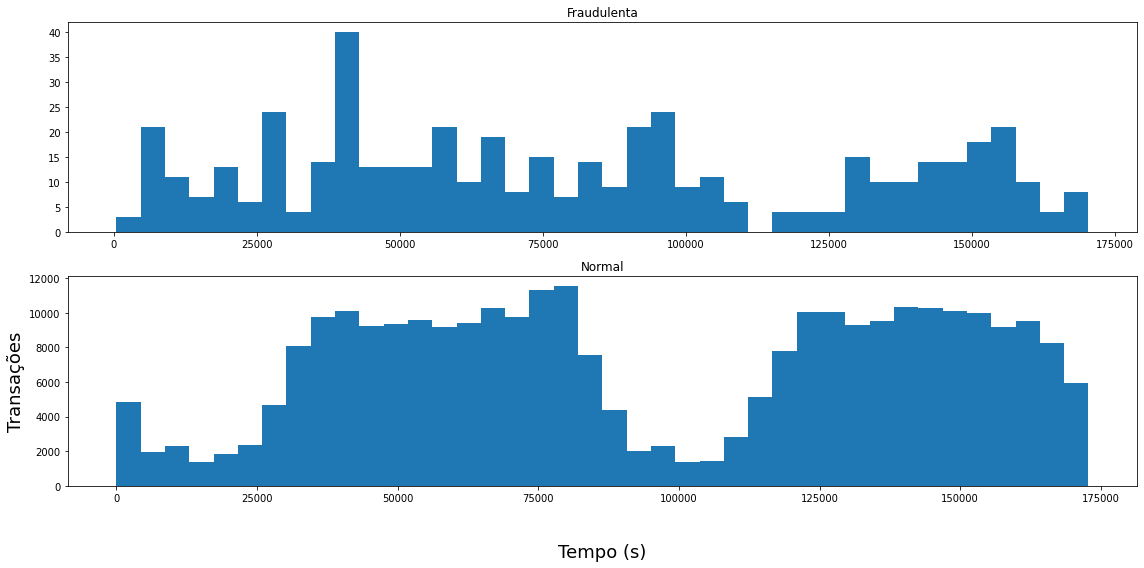

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16,8))

ax[0].hist(df.Time.loc[df.Class == 1], bins = 40)
ax[1].hist(df.Time.loc[df.Class == 0], bins = 40)

ax[0].set_title('Fraudulenta')
ax[1].set_title('Normal')

plt.xlabel('Tempo (s)', labelpad = 40, fontsize=18)
plt.ylabel('Transações', fontsize=18)


plt.tight_layout()

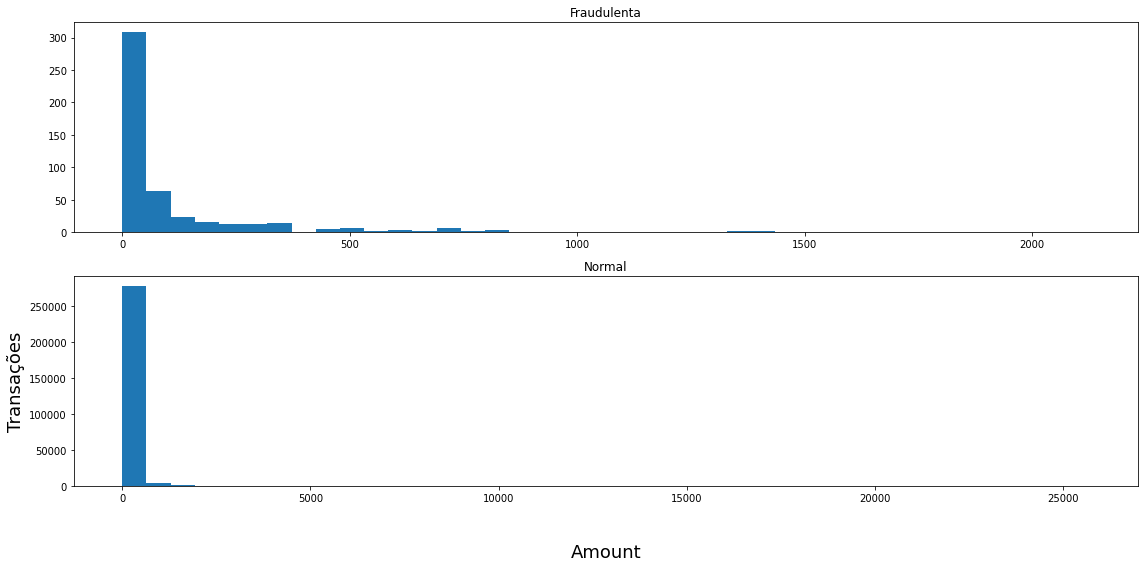

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16,8))

ax[0].hist(df.Amount.loc[df.Class == 1], bins = 40)
ax[1].hist(df.Amount.loc[df.Class == 0], bins = 40)

ax[0].set_title('Fraudulenta')
ax[1].set_title('Normal')

plt.xlabel('Amount', labelpad = 40, fontsize=18)
plt.ylabel('Transações', fontsize=18)


plt.tight_layout()

Para conseguir analisar melhor a variável Amount, e como se comporta diante do tipo de transação, podemos usar um boxplot e um resumo estatístico somente dela. Fazendo isso, vemos que tanto a classe fraudelenta quanto a classe normal possuem muitos valores que podem ser considerados como outliers.

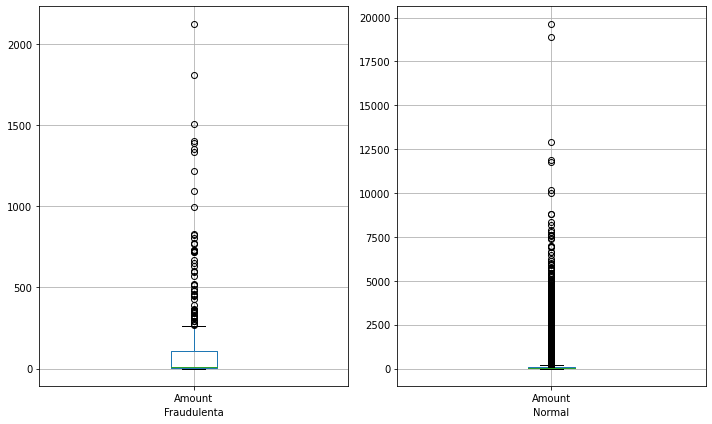

In [ ]:
fig, (ax0, ax1) = plt.subplots(figsize = (10,6), ncols = 2)

df_train.loc[df.Class == 1].boxplot(['Amount'], ax = ax0)
df_train.loc[df.Class == 0].boxplot(['Amount'], ax = ax1)

ax0.set_xlabel('Fraudulenta')
ax1.set_xlabel('Normal')

plt.tight_layout()



Nesse resumo é mais fácil de ver como o último quadrante tem um espectro de valores muito alto.

In [ ]:
df.loc[df.Class == 1].Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Com o intuito de ver como os dados se comportarão num modelo, é interessante analisarmos como todas as variáveis se distribuem nas duas classes. Para isso vamos analisá-las com uma matriz de correlação. É interessante nesse tipo de visualização procurar por variáveis que possuem um padrão distinto entre as duas classes. Como pode ser visto, as variáveis V3, V4 e V10 podem auxiliar na identificação.

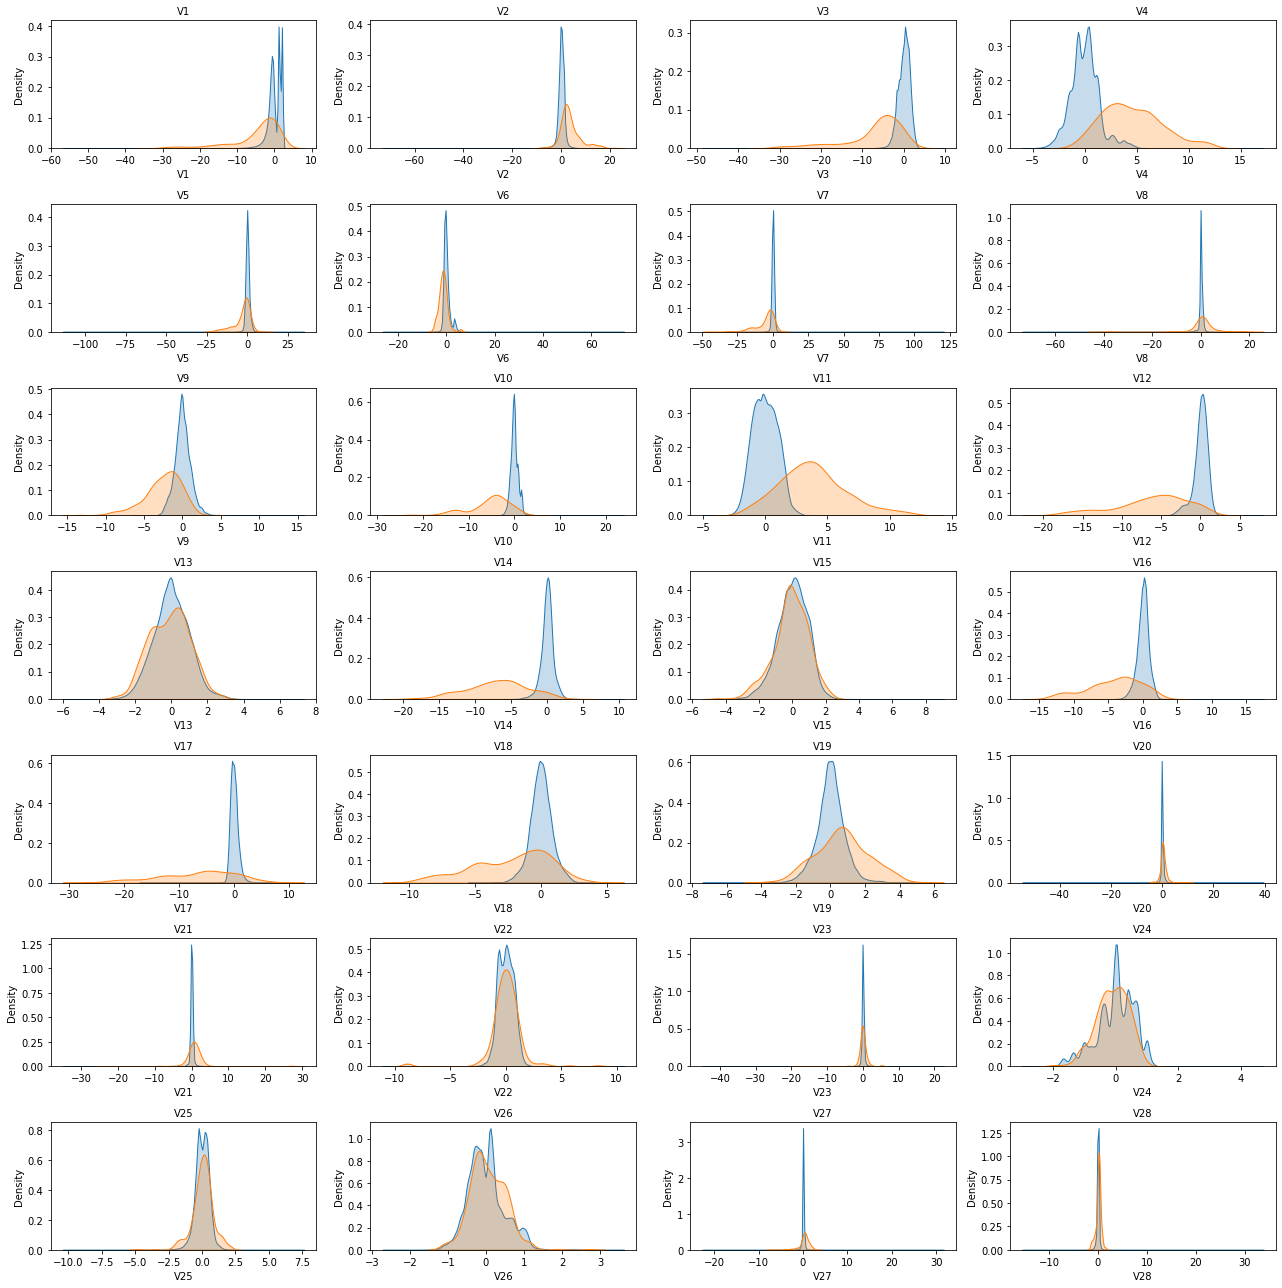

In [ ]:
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()


O que podemos tirar de aprendizado dessa etapa de análise dos dados:


*   Não há valores nulos no dataset.
*   As duas classes estão bem desbalanceadas.
*   As únicas variaveis que não foram padronizadas são Amount e Time.
*   Ambas as classe possuem valores de outliers.


#**Preparação dos Dados**

Nessa etapa que precede a aplicação do modelo, vamos preparar os dados para termos um encaixe melhor do modelo. Essa preparação vai consistir em:
*   Padronzar as variáveis Time e Amount.
*   Separar em datasets de treino e teste.
*   Equalizar a proporção entre as duas Classes nos datasets.

Primeiro vamos padronizar as duas colunas que não vieram padronizadas do dataset original, Time e Amount. Para isso, vamos utilizar a classe **StandardScaler**. Essa classe do sklearn vai fazer com que a variável siga uma distribuição normal de média 0, e os dados serão a variância.

In [ ]:
df_std = df.copy()

stdsclaer = StandardScaler()

df_std['std_time'] = stdsclaer.fit_transform(df.Time.values.reshape(-1,1))
df_std['std_amount'] = stdsclaer.fit_transform(df.Amount.values.reshape(-1,1))

df_std.drop(['Amount', 'Time'], axis = 1, inplace =  True)

df_std[['std_time', 'std_amount']].head(10)

,std_time,std_amount
0,-1.996583,0.244964
1,-1.996583,-0.342475
2,-1.996562,1.160686
3,-1.996562,0.140534
4,-1.996541,-0.073403
5,-1.996541,-0.338556
6,-1.996499,-0.333279
7,-1.996436,-0.190107
8,-1.996436,0.019392
9,-1.996394,-0.338516


Vamos agora dividir o dataset padronizado entre treino e teste. E como a proporção entre as classes (fraudulenta e normal) é bem desigual, usamos stratify=True na divisão. Assim, a proporção entre as classes ficará igual entre os datasets (treino e teste).

In [ ]:
X = df_std.drop(['Class'], axis = 1)
Y = df_std.Class

x_train, x_test, y_train, y_test = train_test_split(X,Y, stratify = Y, shuffle = True)

Agora um outro problema será resolvido: a enorme diferença entre a quantidade de cada classe no mesmo dataset, como pode ser visto abaixo. Para isso, vamos utilizar a biblioteca imblearn, que fará o balanceamento.

In [ ]:
rus = RandomUnderSampler()
x_rus, y_rus = rus.fit_resample(x_train, y_train)

sampler = {'Antes - Normal': y_train.value_counts().values[0]
           ,'Antes - Fraudulenta': y_train.value_counts().values[1]
           ,'Depois - Normal': y_rus.value_counts().values[0]
           ,'Depois - Fraudulenta': y_rus.value_counts().values[1]}

print(sampler)

{'Antes - Normal': 213236, 'Antes - Fraudulenta': 369, 'Depois - Normal': 369, 'Depois - Fraudulenta': 369}


Feito todos esses ajustes, podemos ver como as variáveis se comportam entre si, ou seja, uma matriz de correlação.

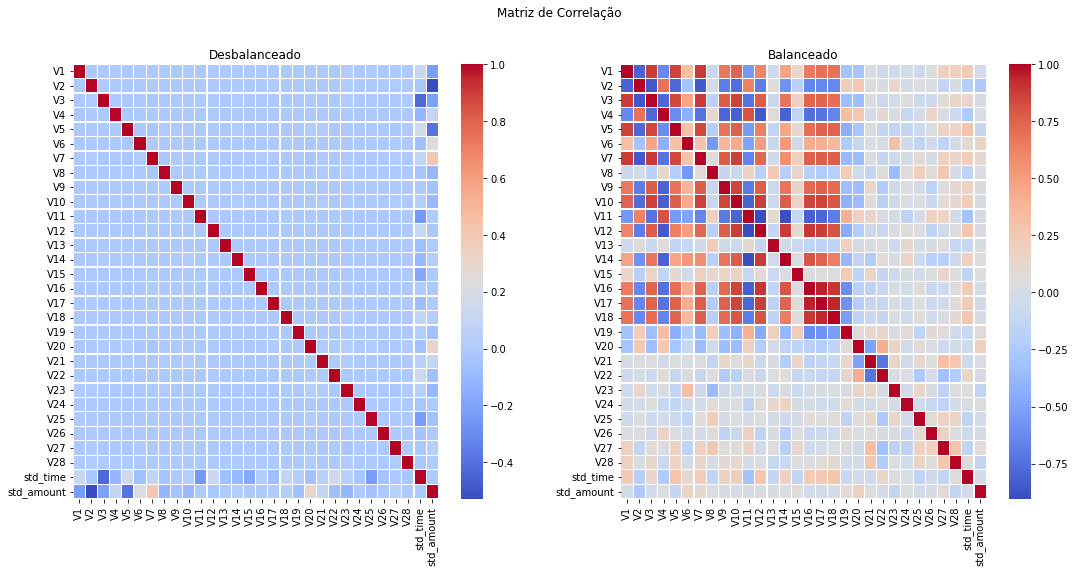

In [ ]:
corr = x_train.corr()
corr_rus = pd.DataFrame(x_rus).corr()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

#**Modelo de Machine Learning**

Tendo feito a preparação dos dados, agora é a etapa em que será feito o treinamento do modelo de Machine Learning. Nesse estudo usaremos a Regressão Logística.

In [ ]:
model = LogisticRegression()
model.fit(x_rus, y_rus)
y_pred = model.predict(x_test)

Com o modelo treinado com os dados de treino, que foram preparados na etapa anterior, podemos fazer a validação do modelo. Vamos usar a acurácia e o AUC. Podemos ver que o nosso modelo atingiu 96% de acurácia e 0,93 de AUC.


Acurácia: 0.96
AUC: 0.93




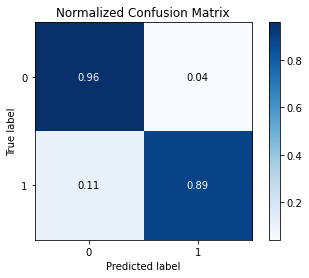

In [ ]:
print(f'Acurácia: {accuracy_score(y_test, y_pred):.2F}')
print(f'AUC: {roc_auc_score(y_test, y_pred):.2F}\n\n')

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize = True)

Agora, faremos novas previsões, mas com os dados de teste que separamos lá no inicio do estudo. Para isso, vamos ter que padronizar novamentes as variaveis Time e Amount. 

In [ ]:
std_scaler = StandardScaler()

df_test['std_time'] = std_scaler.fit_transform(df_test['Time'].values.reshape(-1,1))
df_test['std_amount'] = std_scaler.fit_transform(df_test['Amount'].values.reshape(-1,1))
df_test.drop(['Time','Amount'], axis = 1, inplace = True)

df_test.head(5)



,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_time,std_amount
183484,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,-1.644401,...,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,0,0.658372,-0.177738
255448,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,-1.192404,...,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,0,1.320094,-0.321945
244749,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,...,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,0,1.219742,0.034666
63919,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,0.133040,...,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,0,-0.919236,0.838765
11475,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,0.113386,...,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,0,-1.572827,-0.310490


In [ ]:
x_df_test = df_test.drop('Class', axis = 1)
y_df_test = df_test['Class']

In [ ]:
y_pred = model.predict(x_df_test)

Realizamos uma nova previsão com o mesmo modelo de antes, agora veremos como essa previsão com um dataset diferente se saiu nas mesmas métricas de avaliação usadas anteriormente: acurácia e AUC.

Acurácia 2: 0.96
AUC 2: 0.95




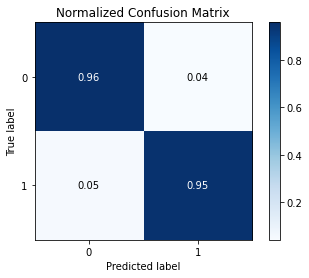

In [ ]:
print(f'Acurácia 2: {accuracy_score(y_df_test, y_pred):.2F}')
print(f'AUC 2: {roc_auc_score(y_df_test, y_pred):.2F}\n\n')

skplt.metrics.plot_confusion_matrix(y_df_test, y_pred, normalize = True)

#**Conclusão**

O modelo final chegou em um bom patamar das suas métricas de avaliação, e foi a parte mais simples de todo o estudo. A maior demanda de tempo foi no entendimento do problema com o desbalanceamento e proporção dos dados. O dataset já vir sem valor ausente e padronizado foram fatores que facilitaram o processo.